# Hamiltonian Simulation with Block-Encoding

This tutorial demonstrates how to implement Hamiltonian simulation for block-encoded Hamiltonians using two different techniques: Quantum Singular Eigenvalues Transform (QSVT) and qubitization. It specializes for a [Linear Combination of Unitaries (LCU)](https://github.com/Classiq/classiq-library/blob/main/algorithms/vqls/lcu_vqls/vqls_with_lcu.ipynb) block-encoding for the Hamiltonian, using unary iteration ([[6](#childs)]; see also [[7](#gidney)]); however, you can easily modify the implementation of the Hamiltonian simulation to other block-encoding implementations.

The tutorial is organized as follows: 

1. Definitions of block-encoding and the Jacobi–Anger Expansion
2. Definitions of classical and quantum functions that are useful for the Hamiltonian block-encoding
3. Definition of a specific Hamiltonian
4. Implementation of a Hamiltonian simulation using QSVT
5. Implementation of a Hamiltonian simulation using qubitization

The two last sections are independent.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *

from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import pi

## Definitions

### Block-Encoding

**Definition**: A $(s, m, \epsilon)$-encoding of a $2^n\times 2^n$ matrix $H$ refers to completing it into a $2^{n+m}\times 2^{n+m}$ unitary matrix $U_{(s,m,\epsilon)-H}$:
$$
U_{(s,m,\epsilon)-H} = \begin{pmatrix}
H/s & * \\
* & *
\end{pmatrix},
$$
with some functional error $\left|\left(U_{(s,m,\epsilon)-H}\right)_{0:2^n-1,0:2^n-1}-H/s \right|\leq \epsilon$. For the most basic use of block-encoding, see the first item in the technical notes at the end of this tutorial.

**Definition**: LCU refers to $(\bar{\alpha}, m, 0)$-block-encoding of a matrix given as a sum of unitaries:
$$
U_{(\bar{\alpha},m,0)-A} =\begin{pmatrix}
A/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } A = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0
$$
with $\bar{\alpha}\equiv\sum^{L-1}_{i=0}\alpha_i$ and $m= \lceil\log_2(L) \rceil$. See the [LCU tutorial](https://github.com/Classiq/classiq-library/blob/main/algorithms/vqls/lcu_vqls/vqls_with_lcu.ipynb) for more details.


This tutorial starts with an exact $(s, m, 0)$-encoding of some Hamiltonian and implements an approximated encoding of its Hamiltonian evolution
$$
U_{(\tilde{s},\tilde{m},\epsilon)-\exp{(iHt)}} = \begin{pmatrix}
\exp{(iHt)}/\tilde{s} & * \\
* & *
\end{pmatrix},
$$
using QSVT and qubitization approaches. Both implementations are based on a polynomial approximation of the function $f(x)=e^{ix}$. In particular, perform the block-encoding of $\cos(Ht)$ and $\sin(Ht)$ and then construct an LCU for $e^{iHt}=\cos(Ht)+i\sin(Ht)$. Therefore, the LCU methodology is employed at least twice: once for the block-encoding of $H$, and the second for block-encoding the sum of sine and cosine.



### The Jacobi–Anger Expansion

The Jacobi–Anger expansion approximates the sine and cosine functions with Chebyshev polynomials as follows [[1](#JAwiki)]:
\begin{eqnarray}
\cos(xt) &=& J_0(t) + 2\sum^{d}_{k=1} (-1)^k J_{2k}(t) T_{2k}(x)\\
\sin(xt) &=& 2\sum^{d}_{k=0} (-1)^k J_{2k+1}(t) T_{2k+1}(x),
\end{eqnarray}
where $J_i(x)$ and $T_i(x)$ are the Bessel function and Chebyshev polynomial of order $i$, respectively, and the degree $d$ is related to the approximation error $\epsilon$ as
$$
d = O\left(t - \frac{\log\epsilon}{1+\log\left(e-\frac{\log(\epsilon)}{t}\right)}\right).
$$

Start with defining a function that gets $\epsilon$ and the evolution time $t$, and returns the Chebyshev coefficients of the sine and cosine functions, using the `scipy` package.

In [2]:
from scipy.special import eval_chebyt, jv


def get_cheb_coef(epsilon, t):
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef

Visualize the approximation for a specific example:

(-0.1, 1.1)

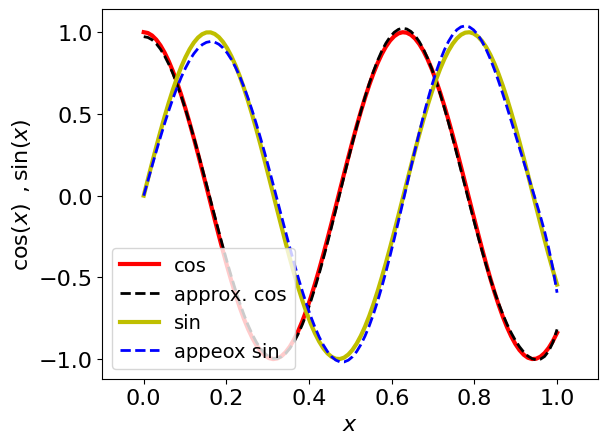

In [3]:
EVOLUTION_TIME = 10
EPS = 0.1

cos_coef, sin_coef = get_cheb_coef(EPS, EVOLUTION_TIME)

xs = np.linspace(0, 1, 100)
approx_cos = sum([cos_coef[k] * eval_chebyt(2 * k, xs) for k in range(len(cos_coef))])
approx_sin = sum(
    [sin_coef[k] * eval_chebyt(2 * k + 1, xs) for k in range(len(sin_coef))]
)
plt.plot(xs, np.cos(EVOLUTION_TIME * xs), "-r", linewidth=3, label="cos")
plt.plot(xs, approx_cos, "--k", linewidth=2, label="approx. cos")
plt.plot(xs, np.sin(EVOLUTION_TIME * xs), "-y", linewidth=3, label="sin")
plt.plot(xs, approx_sin, "--b", linewidth=2, label="appeox sin")
plt.ylabel(r"$\cos(x)\,\,\, , \sin(x)$", fontsize=16)
plt.xlabel(r"$x$", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc="lower left", fontsize=14)
plt.xlim(-0.1, 1.1)

## Building LCU for Pauli Strings

Focus on Hamiltonians that are given in the Pauli basis, i.e., as a sum of unitaries
$$
H = \sum^{L-1}_{i=0} \alpha_i U_i,
$$
where $U_i$ are Pauli strings. Next, define quantum and classical functions relevant for LCU. 

### Classical Pre-process Functions

The LCU is implemented with the so-called "prepare" and "select" operations. The former prepares a quantum state that corresponds to the probabilities $\alpha_i /\sum\alpha_i$. Define a function that gets the list of $L$ coefficients and returns the probabilities to be loaded as part of the LCU. 

In [4]:
def get_normalized_lcu_coef(lcu_coef):
    normalization_factor = sum(lcu_coef)
    prepare_prob = [c / normalization_factor for c in lcu_coef]
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))

    print("The size of the block encoding:", coef_size)
    print("The normalized coefficients:", prepare_prob)
    print("The normalization factor:", normalization_factor)

    return normalization_factor, coef_size, prepare_prob

### Quantum Functions

 Define a quantum function `lcu_paulis` that implements the LCU of Pauli strings with these arguments:
 - `pauli_terms_list`: the list of Pauli strings
 -  `probs`: the normalized coefficients $\alpha_i/\sum\alpha_i$
 -   `data`: the quantum variable on which the Hamiltonian operates
 -   `block`: the quantum "prepare" variable for the block-encoding

Define and use a subroutine `apply_pauli_term` that applies a single Pauli string.
For convenience, restrict the case so that all the coefficients in the LCU are positive ones (see the second technical comment at the end of this notebook).

Note that, using `controlled_selectV(ops: QCallableList[QBit, QArray[QBit]], q: QBit, xs: QArray, target: QArray)` from SelectV.py, we can implement this LCU more efficiently than the naive implementation:
```
repeat(
    count = ops.len,
    iteration = lambda index: if_(
        condition = (index == xs),
        then = lambda: ops[index]
    )
)
```
The key observation is that when these comparisons are performed with multiple intermediate ancillas, the intermediate results can be reused, so a slight increase in width leads to considerable savings in depth.

In [5]:
@qfunc
def apply_pauli_term(pauli_string: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                lambda: X(x[pauli_string.pauli.len - index - 1]),
                lambda: Y(x[pauli_string.pauli.len - index - 1]),
                lambda: Z(x[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )

#SelectV needs a controlled version
@qfunc
def apply_controlled_pauli_term(pauli_string: PauliTerm, c: QBit, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                lambda: CX(c, x[pauli_string.pauli.len - index - 1]),
                lambda: CY(c, x[pauli_string.pauli.len - index - 1]),
                lambda: CZ(c, x[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )

#modified to use SelectV.py
import SelectV as sv
from classiq.qmod.symbolic import log, ceiling
from classiq.interface.helpers.datastructures import get_sdk_compatible_python_object
from classiq.interface.generator.expressions.proxies.classical.qmod_struct_instance import QmodStructInstance

#given a list of floats, "reverse the endian-ness" of the indices.
def reverse_endian_list(probs: list[float], num_bits: int):
    newlist = np.zeros(int(2 ** num_bits))
    for i in range(len(probs)):
        newlist[sv.reverse_endian(i, num_bits)] = probs[i]
    return newlist


@qfunc
def lcu_paulis(
    pauli_terms_list: CArray[PauliTerm],
    probs: CArray[CReal],
    block: QNum,
    data: QArray[QBit],
):
    control_bit = QBit()
    within_apply(
        lambda: [allocate(control_bit),
                X(control_bit)],
        lambda: controlled_lcu_paulis(pauli_terms_list, probs, control_bit, block, data)
    )

#for use in section 2.
@qfunc(generative=True)
def controlled_lcu_paulis(
    pauli_terms_list: CArray[PauliTerm],
    probs: CArray[CReal],
    cb: QBit,
    block: QNum,
    data: QArray[QBit],
):
    #Ori told me to do this, fixes a lambda bug
    pauli_terms_list = get_sdk_compatible_python_object(
        [p if not isinstance(p, QmodStructInstance) 
        else PauliTerm(pauli=p.fields["pauli"], coefficient=p.fields["coefficient"]) 
        for p in pauli_terms_list])
    num_bits = int(np.ceil(np.log2(pauli_terms_list.len)))
    rev_probs = reverse_endian_list(probs, num_bits)

    #need inner scope for lambda list comprehension to work
    
    def pauli_terms_lambda(p: PauliTerm):
        return lambda ctrl, sys: apply_controlled_pauli_term(p, ctrl, sys)
        
    pauli_lambda_list = [pauli_terms_lambda(p) for p in pauli_terms_list]

    within_apply(
        lambda: inplace_prepare_state(rev_probs, 0.0, block),
        lambda: sv.controlled_selectV(pauli_lambda_list, cb, block, data)
    )

### Classical Post-process Functions


Working with block-encoding typically requires post-selection of the block variables being at state 0 (see the first technical note at the end of this tutorial). The success of this process can be amplified via a [Quantum Amplitude Amplification](https://github.com/Classiq/classiq-library/blob/main/algorithms/qsvt/qsvt_fixed_point_amplitude_amplification) routine. This issue is beyond the scope of this tutorial, instead, simply work with a statevector simulator. Define a function that gets execution results and returns a projected state vector. 

In [6]:
## fix the execution preferences for this tutorial
Execution_Prefs = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

In [7]:
def get_projected_state_vector(
    execution_result, measured_var: str, projections: dict, state_size
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    projections: on which values of the other variables to project, e.g., {"ind": 1}
    state_size: measured state vector size
    """

    def _get_var(var: str, state):
        keys = var.split(".")
        val = state
        for k in keys:
            val = val[k]
        return val

    res = execution_result[0].value
    proj_statevector = np.zeros(state_size).astype(complex)
    for sample in res.parsed_state_vector:
        if all(
            _get_var(key, sample.state) == projections[key]
            for key in projections.keys()
        ):
            proj_statevector[
                int(_get_var(measured_var, sample.state))
            ] += sample.amplitude
    return proj_statevector

## Taking a Specific Example

For simplicity in the next sections, take a specific Hamiltonian:
$$
H = 0.4 \cdot I\otimes I +0.1\cdot  I\otimes Z + 0.3 \cdot X \otimes X + 0.2\cdot  Z\otimes Z
$$

In [8]:
HAMILTONIAN = [
    PauliTerm(pauli=[Pauli.I, Pauli.I], coefficient=0.4),
    PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=0.1),
    PauliTerm(pauli=[Pauli.X, Pauli.X], coefficient=0.05),
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.2),
]

Next, calculate the normalized coefficients for the LCU and the corresponding normalization factor:

In [9]:
lcu_pauli_coef = [p.coefficient for p in HAMILTONIAN]
normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
    lcu_pauli_coef
)

The size of the block encoding: 2
The normalized coefficients: [0.5333333333333333, 0.13333333333333333, 0.06666666666666667, 0.26666666666666666]
The normalization factor: 0.75


### Verifying the Hamiltonian Block-encoding

Before moving to the more complex Hamiltonian simulation implementation, it is useful to verify the Hamiltonian block-encoding. For this, define a model in which to apply $U_H$ on some random vector state of size $2^n\cdot 2^m$, $(\vec{b},\vec{0})$, and verify that the resulting state, after post-selection, gives $(H/\bar{\alpha})\vec{b}$: 

In [10]:
data_size = len(HAMILTONIAN[0].pauli)
b = np.random.rand(2**data_size)
b = (b / np.linalg.norm(b)).tolist()

In [11]:
@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    allocate(lcu_size_ham, block)
    prepare_amplitudes(b, 0.0, data)
    lcu_paulis(HAMILTONIAN, prepare_probs_ham, block, data)


qmod_1 = create_model(main, execution_preferences=Execution_Prefs)
qprog_1 = synthesize(qmod_1)
show(qprog_1)

Opening: https://platform.classiq.io/circuit/2uwaUwsrbcP8lSJPBwWrnkBZbiR?login=True&version=0.73.0


In [12]:
res_1 = execute(qprog_1).result()

Use the predefined function for the post-selection:

In [13]:
state_result_1 = get_projected_state_vector(res_1, "data", {"block": 0.0}, len(b))

To compare to the expected result, define classical functions that get the matrix in the standard basis:

In [14]:
PAULI_MATRICES_DICT = {
    Pauli.I: np.array([[1, 0], [0, 1]], dtype=np.complex128),
    Pauli.Z: np.array([[1, 0], [0, -1]], dtype=np.complex128),
    Pauli.X: np.array([[0, 1], [1, 0]], dtype=np.complex128),
    Pauli.Y: np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


def pauli_list_to_mat(pauli_list: list) -> np.ndarray:
    real_matrix = 0
    for term in pauli_list:
        single_str = PAULI_MATRICES_DICT[term.pauli[0]]
        for pauli in term.pauli[1:]:
            single_str = np.kron(single_str, PAULI_MATRICES_DICT[pauli])
        real_matrix += term.coefficient * single_str

    assert np.allclose(
        np.transpose(np.conjugate(real_matrix)), real_matrix
    ), "matrix not Hermitian"
    assert np.allclose(np.imag(real_matrix), 0.0), "matrix is not real valued"
    return np.real(real_matrix)

In [15]:
matrix = pauli_list_to_mat(HAMILTONIAN)

The quantum state that returns from execution is given up to some global phase. To compare to the expected state, run these lines:

In [16]:
expected_state_1 = matrix / normalization_ham @ b
relative_phase = np.angle(expected_state_1[0] / state_result_1[0])
state_result_1 = state_result_1 * np.exp(1j * relative_phase)

In [17]:
print("The resulting state:", np.real(state_result_1))
print("The expected state:", expected_state_1)
assert np.allclose(np.real(state_result_1), expected_state_1)

The resulting state: [0.52500806 0.11995551 0.16169777 0.17672803]
The expected state: [0.52500806 0.11995551 0.16169777 0.17672803]


## Hamiltonian Simulation with Qubitization

Given the block-encoding $U_{(s,m,0)-H}$, define the following operator (usually called the Szegedy quantum walk operator [[5](#Szegedy)]):
$$
W\equiv -\Pi_{|0\rangle_m} U_{(s,m,0)-H},
$$  
where $\Pi_{|0\rangle_m}$ is a reflection operator about the block state. This unitary function has the important property that its powers correspond to a $(1,m,0)$-encoding of the Chebyshev polynomials:
$$
W^k = \begin{pmatrix}
T_k(H) & * \\
* & *
\end{pmatrix}=U_{(1,m,0)-T_k(H)},
$$
with $T_k$ being the k-th Chebyshev polynomial. For more details, see Sec. 7 in Ref. [[2](#Qubitization)]. (The property holds only for Hermitian block-encoding. For generalization, see comment 3 below.) You can thus simply combine the Jacobi–Anger expansion with the LCU technique to get the block-encoding for the Hamiltonian simulation. Namely, you have an $\epsilon$-approximation of $\exp(iHt)\approx \sum^d_{i=0} \beta_{i} T_{i}(x)$, for which you can perform the following encoding:
$$
U_{(\bar{\beta},\tilde{m},\epsilon)-\exp{(iHt)}} =
\begin{pmatrix}
\exp{(iHt)}/\bar{\beta} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} U_{(1,m,0)-T_k(H)} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} T_{k}(Ht) & * \\
* & *
\end{pmatrix}
=\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} W^k & * \\
* & *
\end{pmatrix},
$$
where $\tilde{m}=m+\lceil \log_2(d+1) \rceil$ (recalling that $W$ are block-encodings themselves, with block size $m$).

Define a walk operator for this specific example. For the reflection, use the `reflect_about_zero` quantum function from the Classiq open library. We also define a controlled version, in order to benefit from the control argument of `controlled_selectV`.

In [18]:
@qfunc
def my_walk_operator(block: QArray[QBit], data: QArray[QBit]) -> None:
    cntrl = QBit()
    within_apply(
        lambda: [
            allocate(cntrl), 
            X(cntrl)
        ],
        lambda: controlled_walk_operator(cntrl, block, data)
    )

@qfunc
def controlled_walk_operator(cntrl: QBit, block: QArray[QBit], data: QArray[QBit]) -> None:
    controlled_lcu_paulis(HAMILTONIAN, prepare_probs_ham, cntrl, block, data)
    control(ctrl=cntrl, stmt_block=lambda: reflect_about_zero(block))
    #RY(2 * pi, block[0])  # for the minus sign
    Z(cntrl)

Next, use the predefined function to calculate the coefficients $\beta_i$ for approximating the sine and cosine functions. Recall that you want to approximate $e^{iHt}$, whereas the Hamiltonian is encoded with a normalization factor $\bar{\alpha}$. Therefore, you must rescale the time by this factor.

In [19]:
normalized_time = normalization_ham * EVOLUTION_TIME

cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)

combined_sin_cos_coef = []
for k in range(len(cos_coef) - 1):
    combined_sin_cos_coef.append(cos_coef[k])
    combined_sin_cos_coef.append(sin_coef[k])
combined_sin_cos_coef.append(cos_coef[-1])
if len(sin_coef) == len(cos_coef):
    combined_sin_cos_coef.append(sin_coef[-1])

Given the coefficients, calculate the probabilities for the LCU "prepare" variable. These must be positive numbers. Moreover, for the odd terms, which correspond to the sine function, add a factor of $i$ to the unitary operations $W^k$. To take this into account, for each term, define a "generalized sign" $\sigma_k$ such that $\beta_k = e^{\frac{\pi}{2}\sigma_k i} |\beta_k|$ with $\sigma_k \in \{0,1,2,3\}$ that corresponds to the factors $1,i,-1,-i$, respectively. 

In [20]:
signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
generalized_signs = [
    (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
]
positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)

Now that you have the positive coefficients, use the predefined preprocess function to get the probabilities for the LCU:

In [21]:
normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(
    positive_cheb_lcu_coef
)

The size of the block encoding: 4
The normalized coefficients: [0.06646302105481754, 0.06750041778530919, 0.11492593070021927, 0.12879424749209278, 0.011890532706545037, 0.14147748237907418, 0.17674611046555386, 0.14131629436581197, 0.08704430568396189, 0.044378224426640044, 0.0194634329399742, 0, 0, 0, 0, 0]
The normalization factor: 4.007336014122894


Define a quantum function for a generic LCU of Chebyshev polynomials, which gets the prepare probabilities, the generalized signs, and a walk operator as a quantum callable. Once again, we can use `controlled_selectV` for some depth savings.

In [22]:
@qfunc(generative=True)
def lcu_cheb(
    coef: CArray[CReal],
    generalized_signs: CArray[CInt],
    walk_operator: QCallable[QNum, QArray],
    walk_block: QNum,
    walk_data: QArray,
    cheb_block: QNum,
):
    num_bits = int(np.ceil(np.log2(coef.len)))
    rev_coef = reverse_endian_list(coef, num_bits)
    c_bit = QBit()

    #need inner scope for lambda list comprehension to work
    def apply_cheb(i: int):
        return lambda ctrl, targ: [
            PHASE(pi / 2 * generalized_signs[i], ctrl),
            power(i, lambda: controlled_walk_operator(ctrl, walk_block, targ)),
        ]   
    cheb_list = [apply_cheb(i) for i in range(generalized_signs.len)]
    
    within_apply(
        lambda: [allocate(c_bit),
                 X(c_bit),
                 inplace_prepare_state(rev_coef, 0.0, cheb_block)],
        lambda: sv.controlled_selectV(cheb_list, c_bit, cheb_block, walk_data)
        ),
    

The code in the rest of this section builds a model that applies the `lcu_cheb` function on the randomly prepared vector $(\vec{b},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results. 

In [23]:
@qfunc
def main(ham_block: Output[QNum], data: Output[QNum], exp_block: Output[QNum]):
    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)
    prepare_amplitudes(b, 0.0, data)
    lcu_cheb(
        prepare_probs_exp,
        generalized_signs,
        lambda x, y: my_walk_operator(x, y),
        ham_block,
        data,
        exp_block,
    )


qmod_2 = create_model(main, execution_preferences=Execution_Prefs)
write_qmod(qmod_2, "hamiltonian_simulation_qubitization", decimal_precision=12)

Synthesize the quantum model and execute it:

In [24]:
qprog_2 = synthesize(qmod_2)
show(qprog_2)

Opening: https://platform.classiq.io/circuit/2uwagYuaKLlvLtg0LTYKR5CDc0F?login=True&version=0.73.0


In [25]:
results_2 = execute(qprog_2).result()

In [26]:
state_result_2 = get_projected_state_vector(
    results_2, "data", {"exp_block": 0.0, "ham_block": 0.0}, len(b)
)

In [27]:
expected_state_2 = (
    1 / normalization_exp * scipy.linalg.expm(1j * matrix * EVOLUTION_TIME) @ b
)
relative_phase = np.angle(expected_state_2[0] / state_result_2[0])
state_result_2 = state_result_2 * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state_2)
print("resulting state:", state_result_2)
assert np.linalg.norm(state_result_2 - expected_state_2) < EPS

expected state: [ 0.09398602+0.10907698j  0.07899411+0.12750637j -0.13267112-0.02741344j
  0.02560255+0.00580194j]
resulting state: [ 0.09269676+0.1075807j   0.07587785+0.12467602j -0.13265756-0.02559468j
  0.02589505+0.00491394j]


In [28]:
print(
    "overlap between expected and resulting state:",
    np.abs(np.vdot(state_result_2, expected_state_2))
    * normalization_exp
    / np.linalg.norm(state_result_2),
)

overlap between expected and resulting state: 0.9999051683241003


***


## Hamiltonian Simulation with QSVT

The QSVT is a general technique for applying block-encoding of matrix polynomials via quantum signal processing. Refer to Ref. [[3](#grand)] and the [QSVT notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/qsvt/qsvt_matrix_inversion/qsvt_matrix_inversion.ipynb) for more information about this generic and important subject. For the QSVT approach, repeatedly apply two operations:  $U_H$ application and rotated reflections around the block space, applied on an extra qubit. The value of the rotation angles is found using the `pyqsp` package. 

The QSVT gives block-encoding of polynomials with a well defined parity. Thus, you apply two QSVT blocks—one for approximating the $\cos(xt)$ function and one for the $\sin(xt)$ function—and then, for the finale, construct an LCU to get the block-encoding of the sum $e^{ixt} = \cos(xt)+i\sin(xt)$. For a realization of such a model on real hardware, see Ref. [[4](#paper)].

Start by calculating the rotation angles for the sine and cosine polynomial approximations. As for the qubitization method, normalize the evolution time $t$. In addition, the `pysqp` adds a factor $1/2$ to the sine and cosine polynomials.

In [29]:
# The following code assumes pyqsp version 0.1.6
# !pip install pyqsp==0.1.6
import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

pg_cos = pyqsp.poly.PolyCosineTX()
pcoefs_cos, scale_cos = pg_cos.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_cos = Polynomial(pcoefs_cos)

pg_sin = pyqsp.poly.PolySineTX()
pcoefs_sin, scale_sin = pg_sin.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_sin = Polynomial(pcoefs_sin)

12.104183283573647
R=6
[PolyCosineTX] rescaling by 0.5.
12.104183283573647
R=6
[PolySineTX] rescaling by 0.5.


In [30]:
ang_seq_cos = QuantumSignalProcessingPhases(
    poly_cos,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)

ang_seq_sin = QuantumSignalProcessingPhases(
    poly_sin,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)


# change W(x) to R(x), as the phases are in the W(x) conventions see Eq.()
def convert_phases_to_Rx_convention(ang_seq):
    phases = np.array(ang_seq)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    phases = -2 * phases

    return phases.tolist()

The list of angles to use within the `qsvt` function are given by

In [31]:
phases_cos = convert_phases_to_Rx_convention(ang_seq_cos)
phases_sin = convert_phases_to_Rx_convention(ang_seq_sin)

Next, use the [Classiq `qsvt` function](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qsvt/qsvt.ipynb) to get the QSVT of the sine and cosine block-encoding. This open library function has the following arguments:
- `phases`: the series of rotations according to quantum signal processing
-  `proj_cnot_1`, `proj_cnot_2`: the projection operations for the block space. In this case, these are identical, defined below as the `identify_block`
- `u`: the block-encoding quantum function—the `lcu_paulis` function
- `qvar`: the combined variables of the block-encoding function
- `qsvt_aux`: the extra qubit for the QSVT rotations

Define a QSVT function for the specific Hamiltonian and approximation. Passing it the `phases_cos` or `phases_sin` series of angles generates the block-encodings:
$$
U_{(2,m+1,\epsilon)-\cos(Ht)} = \begin{pmatrix}
\cos(iHt)/2 & * \\
* & *
\end{pmatrix}, \,\,\,\,\,\,
U_{(2,m+1,\epsilon)-\sin(Ht)} = \begin{pmatrix}
\sin(iHt)/2 & * \\
* & *
\end{pmatrix}
$$  
where the extra qubit and factor $1/2$ in the encoding comes from the QSVT.


In [32]:
class BlockEncodedState(QStruct):
    block: QNum[lcu_size_ham, False, 0]
    data: QNum[np.ceil(np.log2(len(b))), False, 0]


@qfunc
def identify_block(state: BlockEncodedState, qubit: QBit):
    qubit ^= state.block == 0


@qfunc
def block_encode_hamiltonian(state: BlockEncodedState):
    lcu_paulis(
        HAMILTONIAN,
        prepare_probs_ham,
        state.block,
        state.data,
    )


# defining a qsvt for the specific example
@qfunc
def my_qsvt(phases: CArray[CReal], qsvt_aux: QBit, state: BlockEncodedState):
    #another local function, to fix the "identify_block not defined" error
    def make_idb():
        return lambda state, qubit: identify_block(state, qubit)
    idb = make_idb()
    qsvt(
        phase_seq=phases,
        proj_cnot_1=idb,
        proj_cnot_2=idb,
        u=block_encode_hamiltonian,
        qvar=state,
        aux=qsvt_aux,
    )

Finally, to get the desired Hamiltonian simulation, apply an LCU with the two unitaries: 
$$
U_{(2,m+1,\epsilon)-\cos(Ht)} + iU_{(2,m+1,\epsilon)-\sin(Ht)}.
$$
The normalized LCU coefficients are therefore $(1/2,1/2)$, giving an $(4, m+2,\epsilon)$-encoding for the Hamiltonian simulation:
$$
U_{((4, m+2,\epsilon))-\exp{(iHt)}} = \begin{pmatrix}
\frac{1}{4}\exp{(iHt)} & * \\
* & *
\end{pmatrix}.
$$

The code in the rest of this section builds a model that applies this block-encoding on the randomly prepared $(\vec{b},\vec{0})$, synthesizes it, executes the resulting quantum program, and verifies the results.

In [33]:
@qfunc
def main(
    qsvt_aux: Output[QBit], block_exp: Output[QBit], state: Output[BlockEncodedState]
):
    allocate(1, qsvt_aux)
    allocate(1, block_exp)
    allocate(state.size, state)
    inplace_prepare_amplitudes(b, 0.0, state.data)
    within_apply(
        lambda: H(block_exp),
        lambda: (
            control(
                block_exp == 0,  # cosine
                lambda: my_qsvt(phases_cos, qsvt_aux, state),
            ),
            control(
                block_exp == 1,  # sine
                lambda: (
                    U(0, 0, 0, pi / 2, qsvt_aux),  # for the i factor
                    my_qsvt(phases_sin, qsvt_aux, state),
                ),
            ),
        ),
    )

In [34]:
qmod_3 = create_model(main, execution_preferences=Execution_Prefs)
write_qmod(qmod_3, "hamiltonian_simulation_qsvt", decimal_precision=12)

In [35]:
qprog_3 = synthesize(qmod_3)
show(qprog_3)

Opening: https://platform.classiq.io/circuit/2uwb2a4vuaOOZ08DfP7ZfVU12Rj?login=True&version=0.73.0


In [36]:
results_3 = execute(qprog_3).result()

In [37]:
state_result_3 = get_projected_state_vector(
    results_3,
    "state.data",
    {"state.block": 0.0, "qsvt_aux": 0.0, "block_exp": 0.0},
    len(b),
)

In [38]:
expected_state_3 = 1 / 4 * scipy.linalg.expm(1j * matrix * EVOLUTION_TIME) @ b
relative_phase = np.angle(expected_state_3[0] / state_result_3[0])
state_result_3 = state_result_3 * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state_3)
print("resulting state:", state_result_3)
assert np.linalg.norm(state_result_3 - expected_state_3) < EPS

expected state: [ 0.09415839+0.10927703j  0.07913899+0.12774022j -0.13291444-0.02746372j
  0.02564951+0.00581258j]
resulting state: [ 0.09414056+0.10925633j  0.07914665+0.127668j   -0.13301447-0.02743087j
  0.02565755+0.00581397j]


In [39]:
print(
    "overlap between expected and resulting state:",
    np.abs(np.vdot(state_result_3, expected_state_3))
    * 4
    / np.linalg.norm(state_result_3),
)

overlap between expected and resulting state: 0.9999998870611411


## Technical Notes

1. Basic use of the block-encoding unitary: Let's say you have a $(s, m, 0)$-encoding of a matrix $A$
$$
U_{(s, m, 0)-A} = \begin{pmatrix}
	 A/s & *  \\
	 * & * 
\end{pmatrix},
$$
where the dimension of $A$ is $2^n\times 2^n$.
If you apply this unitary on the state 
$$
|\psi\rangle_n|0\rangle_m =|\psi\rangle_n \otimes 
\begin{pmatrix}
	 1  \\
      0\\
	 \vdots \\
  0
\end{pmatrix} =  
\begin{pmatrix}
	 |\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix},
$$
you  get
$$
U_{(s, m, 0)-A} \left(|\psi\rangle_n|0\rangle_m \right)  = 
\begin{pmatrix}
	 \frac{1}{s}A|\psi\rangle_n  \\
      0\\
	 \vdots \\
  0
\end{pmatrix}
+
\begin{pmatrix}
	 0  \\
      *\\
	 \vdots \\
  *
\end{pmatrix} = \frac{1}{s}A|\psi\rangle_n|0\rangle_m +\sum_{l\neq 0} c_l |\phi\rangle_n|l\rangle_m .
$$
Thus, if you measure $|0\rangle_m$ on the second variable, you know the first variable is the state $\frac{1}{s}A|\psi\rangle_n$. In terms of measurement, post-select on $|0\rangle_m$ to measure the desired state. You can amplify the success of this operation, given by $|\frac{1}{s}A|\psi\rangle_n|$, with Quantum Amplitude Amplification.


2. Generalization to Pauli strings with non-positive coefficients: The assumption that all the coefficients $\alpha_i$ in the Hamiltonian decomposition to Pauli strings are positive can be easily relaxed by entering non-positive or complex coefficients into the definition of $U_i$. Thus, you can modify `get_cheb_coef` to return the "generalized signs" and add phases to the Pauli strings accordingly, as in the qubitization method above.

3. Generalization to non-Hermitian block-encoding: This tutorial took a Hermitian Hamiltonian block-encoding; that is, the unitary $U_{(s,m,0)-H}$ itself is Hermitian. In the case of non-Hermitian unitary block-encoding, the cited property of the walk operator $W$ does not hold. However, a similar property holds for $\tilde{W}\equiv U_{(s,m,0)-H}^T\Pi_{|0\rangle_m} U_{(s,m,0)-H}\Pi_{|0\rangle_m}$. (See Sec. 7.4 in Ref. [[2](#qubitization)].)

<a id='JAwiki'>[1]</a>: [Jacobi-Anger Expansion](https://en.wikipedia.org/wiki/Jacobi%E2%80%93Anger_expansion).

<a id='qubitization'>[2]</a>: [Lin, L. "Lecture notes on quantum algorithms for scientific computation
." arXiv:2201.08309 \[quant-ph\])](https://arxiv.org/abs/2201.08309).

<a id='grand'>[3]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. "Grand unification of quantum algorithms." PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)

<a id='paper'>[4]</a>: [Kikuchi, Y, Mc Keever, C, Coopmans, L, et al. "Realization of quantum signal processing on a noisy quantum computer". npj Quantum Inf 9, 93 (2023)](https://www.nature.com/articles/s41534-023-00762-0).

<a id='Szegedy'>[5]</a>: [M. Szegedy, "Quantum speed-up of Markov chain based algorithms," In 45th Annual IEEE symposium on foundations of computer science, pages 32–41, 2004](https://ieeexplore.ieee.org/abstract/document/1366222).

<a id='childs'>[6]</a>: [A.M. Childs, D. Maslov, Y. Nam, N.J. Ross, & Y. Su, Toward the first quantum simulation with quantum speedup, Proc. Natl. Acad. Sci. U.S.A. 115 (38) 9456-9461, https://doi.org/10.1073/pnas.1801723115 (2018).](https://doi.org/10.1073/pnas.1801723115)

<a id='gidney'>[7]</a>: [Khattar, T., & Gidney, C. (2024). Rise of conditionally clean ancillae for optimizing quantum circuits. arXiv preprint arXiv:2407.17966.](https://arxiv.org/abs/2407.17966).
